<a href="https://colab.research.google.com/github/FarahZayed/Qr-detector/blob/master/cv_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import** **libraries**

In [103]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image, ImageFilter
import math
from matplotlib import pyplot as plt

2ara el sora

In [110]:
img = cv2.imread("/content/drive/MyDrive/testcases/CSE483 Sp24 Project Test Cases/06-Railfence-cipher.png", cv2.IMREAD_GRAYSCALE)
_, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)

** Function ma7tgnha**

In [120]:
def remove_quietnoise(img):
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1
    for row_index, row in enumerate(img):
     for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
     if start_row != -1:
        break
    for row_index, row in enumerate(img[::-1]):
     for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
     if end_row != -1:
        break
    for col_index, col in enumerate(cv2.transpose(img)):
     for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
     if start_col != -1:
        break
    for col_index, col in enumerate(cv2.transpose(img)[::-1]):
     for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
     if end_col != -1:
        break
    qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
    return qr_no_quiet_zone
    fig = plt.figure(figsize=(5, 5));
    plt.xticks([], []);
    plt.yticks([], []);
    fig.get_axes()[0].spines[:].set_color('red');
    fig.get_axes()[0].spines[:].set_linewidth(40);
    fig.get_axes()[0].spines[:].set_position(("outward", 20))
    plt.title('QR code without quiet zone', y = 1.15, color='red');
    plt.imshow(qr_no_quiet_zone, cmap='gray');


def getcellsize(imgremove):
    size=0
    if(imgremove[0][0]==255):
     for pixel in imgremove[-1, ::-1]:
      if (pixel != 0): break
      size += 1

    elif (imgremove[0][0]==0) :
     for pixel in imgremove[0]:
      if (pixel != 0): break
      size += 1
    else:
        return 0
    grid_cell_size = round(size/7)
    return grid_cell_size


function ll check btrg3 el flag

In [121]:
#Note: rotation hat crash fi sorten 3ashan el binrization bytl3 kolo aswd aw kolo abyd fa mmken na3ml binarize 7asb el case
#mesh 3arfa nashof?? PLUS el banana mafrod ttl3 anha rotated!!! mesh 3arf bardo
def checkrotation(img):
    imgremove = remove_quietnoise(img)
    grid_cell_size= getcellsize(imgremove)
    if grid_cell_size==0:
        print("The image seems to have other noise that must be solved first!!!")
        return False
    inverted_img = cv2.bitwise_not(imgremove)
    se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3*grid_cell_size-1, 3*grid_cell_size-1))
    _, se_binarized = cv2.threshold(se_rect, 128, 1, cv2.THRESH_BINARY)
    se_binarized = se_binarized.astype(int)
    se_binarized[se_binarized == 0] = -1
    erosion = cv2.erode(inverted_img, se_rect, iterations=1)
    plt.imshow(erosion,cmap='gray');
    partwithrotato=erosion[(imgremove.shape[0]-7*grid_cell_size):imgremove.shape[0], imgremove.shape[1]-7*grid_cell_size:imgremove.shape[1]];
    for row in range(partwithrotato.shape[0]):
        for col in range(partwithrotato.shape[1]):
            if partwithrotato[row,col] == 255:
                print("ROTATEDDD!!!")
                return True
    print("NOT ROTATED!!!")
    return False

flags ll preprocessing

In [122]:
rotationflag= checkrotation(img)

The image seems to have other noise that must be solved first!!!


Function el preprocessing

In [123]:
def a3dlrotation(img):
    imgremove = remove_quietnoise(img)
    while(checkrotation(imgremove)):
        imgremove = cv2.rotate(imgremove, cv2.ROTATE_90_CLOCKWISE)
    return imgremove

numbre 6


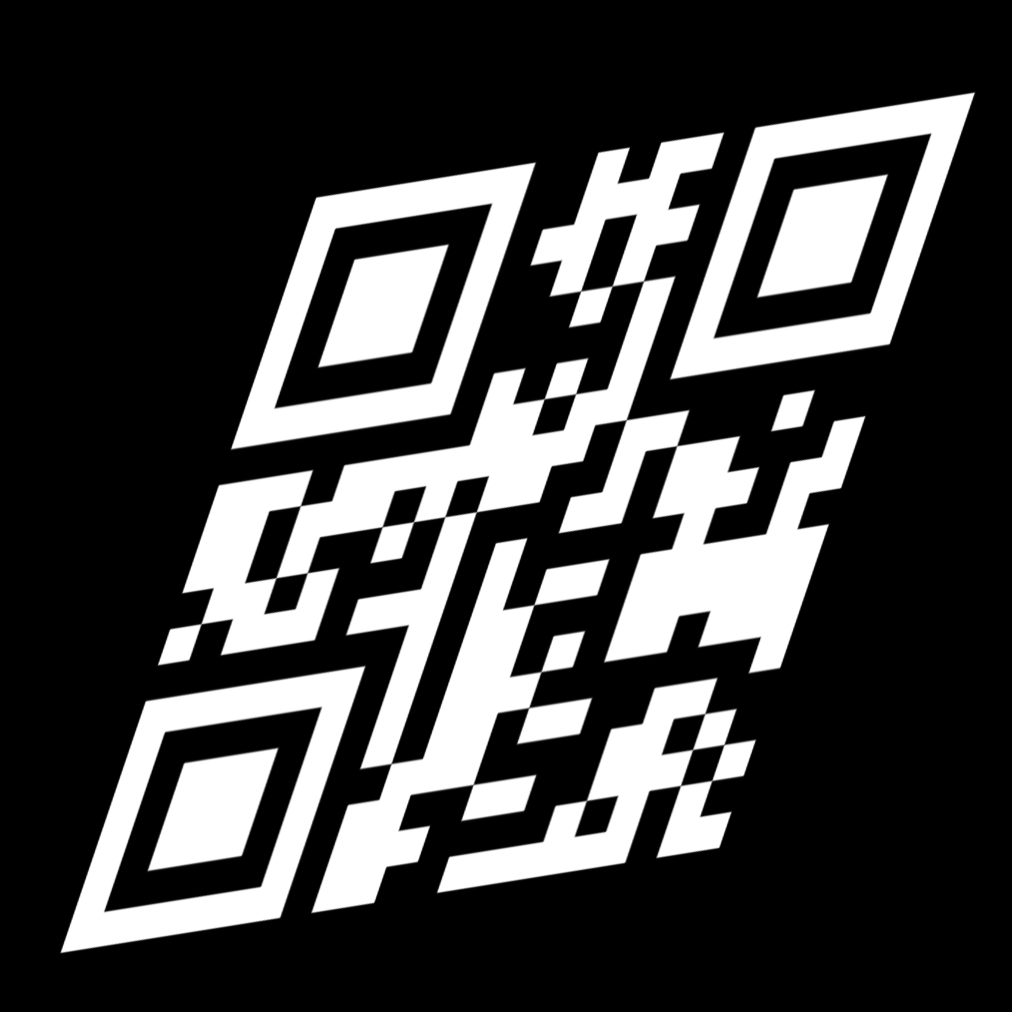

point nr = 0  -> distance = 3.0
----------------------
[780 666]
[718 847]
[333 909]
----------------------
----------------------
[718 847]
[333 909]
[ 61 952]
----------------------
point nr = 2  -> angle = 179.835133564835
----------------------
[333 909]
[ 61 952]
[217 489]
----------------------
----------------------
[ 61 952]
[217 489]
[317 197]
----------------------
point nr = 4  -> angle = 179.71579556765448
----------------------
[217 489]
[317 197]
[970  93]
----------------------
----------------------
[317 197]
[970  93]
[780 666]
----------------------
----------------------
[970  93]
[780 666]
[718 847]
----------------------
point nr = 0  -> angle = 179.4364515027946
*************
718
847
*************
*************
61
952
*************
*************
317
197
*************
*************
970
93
*************
+++++++++++
[(718, 847), (61, 952), (317, 197), (970, 93)]
++++++++++++++


Text(0.5, 1.0, 'AFTER')

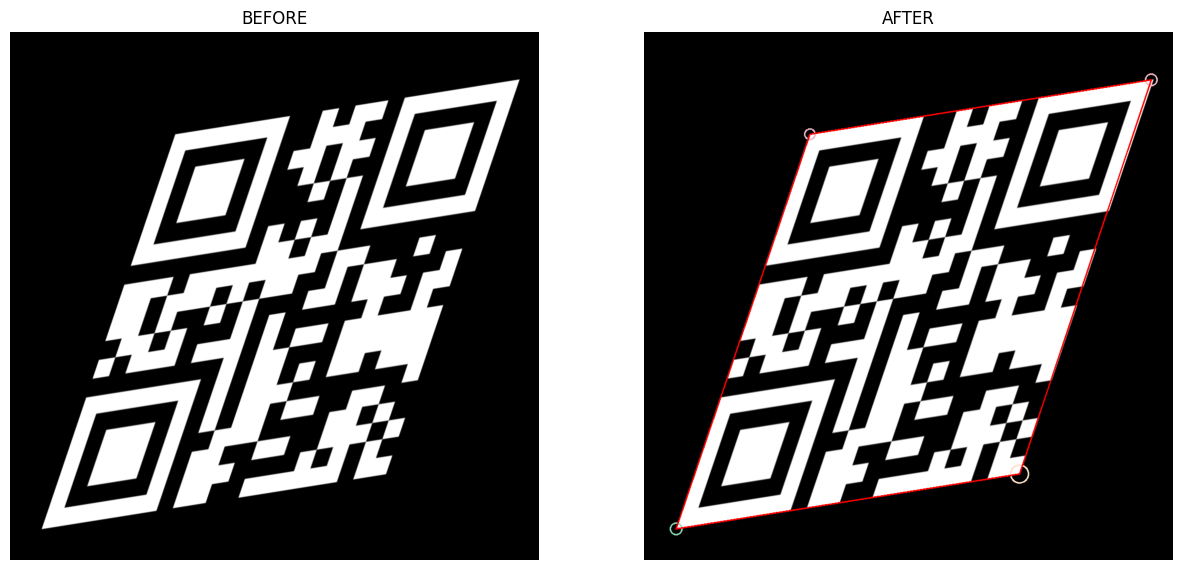

In [124]:
def invert_image(image):
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Invert the grayscale image
    inverted_gray = 255 - image

    # Convert the inverted grayscale image back to BGR (if needed)
    inverted_image = cv2.cvtColor(inverted_gray, cv2.COLOR_GRAY2BGR)

    return inverted_image

def angle_ABC(a, b, c):

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def find_bad_dists(hull, distance = 10):
    mask = []
    points, _, _ = hull.shape

    for i in range(points):
        # determine points to compare and make sure that last and first are compared too
        ai = i
        bi = (i+1)%points
        # x, y for both points
        x1 = hull[ai][0][0]
        y1 = hull[ai][0][1]
        x2 = hull[bi][0][0]
        y2 = hull[bi][0][1]

        #distance
        dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 )
        #build mask with distances out ot range
        if dist < distance:
            print('point nr =', bi, ' -> distance =',dist)
            mask.append(bi)
    return mask



def find_bad_angles(hull, acute_angle = 30, obtuse_angle = 140):

    mask = []
    points, _, _ = hull.shape

    for i in range(points):
        # determine points to compare angle and make sure that last and first are compared too
        ai = i
        bi = (i+1)%points
        ci = (i+2)%points

        #print('ai = ', ai,'bi = ',bi, 'ci = ', ci)
        #selecting points for angle
        a = hull[ai][0]
        b = hull[bi][0]
        c = hull[ci][0]
        print("----------------------")
        print(a)
        print(b)
        print(c)
        print("----------------------")
        #obtain angles
        angle = angle_ABC(a, b, c)
        #print(angle, bi)
        #build mask with angles out ot range
        if angle > obtuse_angle or angle < acute_angle:
            print('point nr =', bi, ' -> angle =',angle)
            mask.append(bi)
    return mask


a_list=[]


def mark_points(hull):

    points, _, _ = hull.shape

    for i in range(points):
        r = int(np.random.randint(100,255,1)[0])
        g = int(np.random.randint(100,255,1)[0])
        b = int(np.random.randint(100,255,1)[0])

        print("*************")



        a_list.append(tuple([hull[i][0][0], hull[i][0][1]]))
        print(hull[i][0][0])
        print(hull[i][0][1])

        print("*************")

        cv2.circle(image, (hull[i][0][0], hull[i][0][1]) , np.random.randint(10,20,1)[0], (r,g,b), 2)







invimg = invert_image(img)

# Display the original and inverted image
from google.colab.patches import cv2_imshow

cv2_imshow( invimg)

cv2.waitKey(0)
cv2.destroyAllWindows()

# img = cv2.imread('/content/drive/MyDrive/testcases/CSE483 Sp24 Project Test Cases/06-Railfence-cipher.png')

invg = cv2.cvtColor(invimg,cv2.COLOR_RGB2GRAY)
ret,thresh = cv2.threshold(invg,127,255,0)

img_raw = invg



# _, contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# _ , contours, hier = cv2.findContours(thresh , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)

image =  invg = cv2.cvtColor(invg,cv2.COLOR_GRAY2RGB)


#size of contour points
length = len(contours)

# here filtering shapes

#concatinate poits form all shapes into one array
# cont = np.vstack(contours[i] for i in range(length))
cont = np.concatenate([contours[i] for i in range(length)], axis=0)



#filter down irreleveant poits
cnt_len = cv2.arcLength(cont, True)
cont = cv2.approxPolyDP(cont, .01*cnt_len, True)
hull = cv2.convexHull(cont)


#filter out poits that are to close to each other
mask = find_bad_dists(hull)
hull = np.delete(hull, mask, axis=0)


#filter out bad corneres, if they are beteween 120-180
#they are random points in the middle of edge
mask = find_bad_angles(hull)
hull = np.delete(hull, mask, axis=0)


#higlight poits
mark_points(hull)
print("+++++++++++")
print(a_list)
print("++++++++++++++")


uni_hull = []
uni_hull.append(hull) # <- array as first element of list
cv2.drawContours(image,uni_hull,-1,255,2)


# fombined figure
fig=plt.figure(figsize=(15, 8))
columns = 2
rows = 1
fig.add_subplot(1, 2, 1)
plt.imshow(img_raw, cmap='gray')
plt.axis('off')
plt.title('BEFORE')

fig.add_subplot(1, 2, 2)
plt.imshow(image)
plt.axis('off')
plt.title('AFTER')



















In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preprocessing

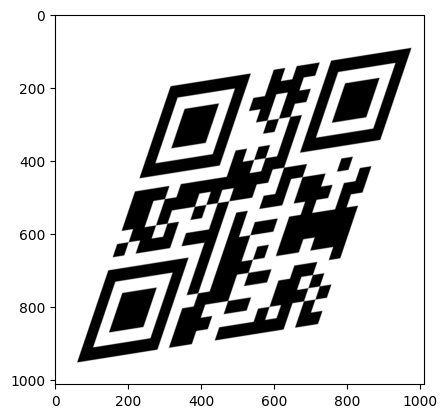

In [125]:
imgafterpreproc=img
if(rotationflag==True):
    imgafterpreproc= a3dlrotation(img)

#ba2et el if

plt.imshow(imgafterpreproc,cmap='gray')

pts1
[[718. 847.]
 [ 61. 952.]
 [317. 197.]
 [970.  93.]]


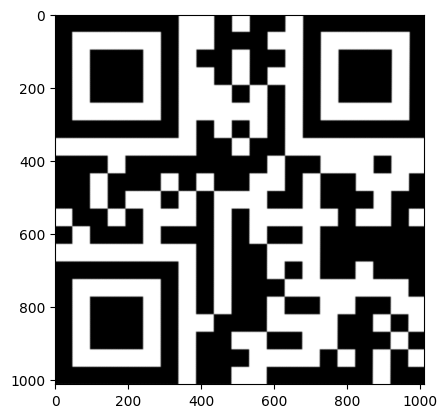

In [126]:
# cv2_imshow(img)
# img = cv2.cvtColor(img,cv2.THRESH_BINARY)
real=img
rows1,cols1=real.shape


# [100,100],[1022,100],[100,1022],[1022,1022]
pts2 = np.float32([[cols1,rows1],[0,rows1],[0,0], [cols1,0]])
pts1 = np.float32(a_list)

# M = cv2.getAffineTransform(pts1,pts2)

# dst = cv2.warpAffine(img,M,(cols,rows))
print("pts1")
print(pts1)

# M = cv2.getAffineTransform(pts1, pts2)
# dst = cv2.warpAffine(sora, M, (cols1, rows1))

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(real,M,(cols1,rows1))

# erode = erode_image(dst)



#back = add_border(dilated)
# [316,197],[974,93],[61,952],[718,847]

# fig.add_subplot(1, 2, 2)
# plt.imshow(dst)
# plt.axis('off')
# plt.title('AFTER')


plt.imshow(dst,cmap='gray')


**Reshape** hy5osh 3ala decode

In [127]:
#later note:mmken nb2a nashel el condition el zayda wala ba an el sora ela 7ad ma htro7 mazbota shwia

def getimageafterreshape(img):
    #dah 3ak ATSRFYYYY
    if(img[0][0]==255):
        imgremove = remove_quietnoise(img)

    else:
        inverted_img = cv2.bitwise_not(img)            #noha 3ayza el invert hena
        imgremove = remove_quietnoise(inverted_img)

    size = 0

    #h8yr hena leh 3ashan el taree2 dih mesh htnf3 3ala kol el sewar zay el rotated fa ana h7sb el 3aded el pixel bel change w inshallah 5er
    if(imgremove[0][0]==255):
        for pixel in imgremove[-1, ::-1]:
         if (pixel != 0): break
         size += 1

    else:
        for pixel in imgremove[0]:
         if (pixel != 0): break
         size += 1
    grid_cell_size = round(size/7)
    print(grid_cell_size)
    grid_cells_num = round(imgremove.shape[0]/grid_cell_size)
    print(grid_cells_num)
    #NOHAAA
    if imgremove.shape[0] % grid_cell_size != 0 or imgremove.shape[1] % grid_cell_size != 0:
        print("Warning: Grid cell size resulted in fraction. Adjusting...")
        img_resized = cv2.resize(imgremove, (924, 924))

# If the resized image is larger than the target size, crop it

        if img_resized.shape[0] > 924 or img_resized.shape[1] > 924:
            imgremove = img_resized[:924, :924]
        else:
            imgremove = img_resized


            #cv2_imshow(imgremove)

    try:

        qr_cells = imgremove.reshape((
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
        )).swapaxes(1, 2)
        plt.imshow(imgremove,cmap='gray')
        _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
        for i, row in enumerate(axes):
          for j, col in enumerate(row):
              col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
              col.get_xaxis().set_visible(False)
              col.get_yaxis().set_visible(False)
              col.spines[:].set_color('red')


        return qr_cells,grid_cells_num,grid_cell_size,imgremove

    except ValueError:
        print("Error: Unable to reshape image into grid cells.")
        return "none",grid_cells_num,grid_cell_size,imgremove



#plt.imshow(imgremove,cmap='gray')

#salama
# print(size)
# grid_cell_size = round(size/7)
# print(grid_cell_size)
# grid_cells_num = round(imgremove.shape[0]/grid_cell_size)
# print(grid_cells_num)
# qr_cells = imgremove.reshape((
#     grid_cells_num,
#     grid_cell_size,
#     grid_cells_num,
#     grid_cell_size,
# )).swapaxes(1, 2)
# plt.imshow(imgremove,cmap='gray')
# _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
# for i, row in enumerate(axes):
#     for j, col in enumerate(row):
#         col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
#         col.get_xaxis().set_visible(False)
#         col.get_yaxis().set_visible(False)
#         col.spines[:].set_color('red')


### Decode

In [128]:
def change_binary(qr_cell,grid_cell_num):
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    return qr_cells_numeric

In [129]:
def getecl(qr_cells_numeric):
    qr_cells_numeric[8]
    # The first two bits determine the error correction level
    # Level L (Low)         [11]	7%  of data bytes can be restored.
    # Level M (Medium)      [10]	15% of data bytes can be restored.
    # Level Q (Quartile)    [01]	25% of data bytes can be restored.
    # Level H (High)        [00]	30% of data bytes can be restored.
    ecl = [int(not(c)) for c in qr_cells_numeric[8, 0:2]]
    # Why "not"? Because the standard uses '1's for black and '0's for white
    #
    # "A dark module is a binary one and a light module is a binary zero."
    #  - ISO/IEC 18004:2000(E)
    #
    # In image processing, we use them the other way.. Hence the inversion
    return ecl

def get_mask(qr_cells_numeric):
    # Dictionary of all masks and their equivalent formulae
    # Same row as above, the three cells after the ecl cells (converted to a string)
    mask = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
    mask_str = ''.join([str(c) for c in mask])
    return mask,mask_str

def get_fec(qr_cells_numeric):
    fec = []
    fec.append(qr_cells_numeric[8, 5])
    fec.append(qr_cells_numeric[8, 7])
    fec.extend(qr_cells_numeric[0:6, 8])
    fec.extend(qr_cells_numeric[7:9, 8])
    fec = [int(not(c)) for c in fec]
    return fec


#def showneededpixel(qr_cells_numeric):
#    _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
#    for i, row in enumerate(axes):
#        for j, col in enumerate(row):

            # col.get_xaxis().set_visible(False)
            # col.get_yaxis().set_visible(False)
            # if (i == 8 and j <= 8) or (i <= 8 and j == 8):
            #     if (i != 6) and (j != 6):
            #         col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
            #         col.spines[:].set_color('red')
            #         continue
            # col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)

In [130]:
def makeinfo(ecl,mask,fec):
    ecl[0] ^= 1
    mask[0] ^= 1
    mask[2] ^= 1
    fec[5] ^= 1
    fec[8] ^= 1

# Before we proceed, let's write a function for masking to make our lives easier


def apply_mask(qr_cells_numeric,data_start_i, data_start_j, direction,UP,DOWN,CW,CCW,UP_ENC,MASKS,mask_str):

    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''

    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

    return result[:4] if direction == UP_ENC else result
# enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
# len = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
# print(len)

In [131]:
def decode(qr_cells,grid_cells_num):
    MASKS = {
        "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
        "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
        "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
        "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
        "100": lambda i, j: i % 2 == 0,
        "101": lambda i, j: (i + j) % 2 == 0,
        "110": lambda i, j: (i + j) % 3 == 0,
        "111": lambda i, j: j % 3 == 0,
    }
    UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"
    qr_cells_numeric=change_binary(qr_cells,grid_cells_num)
    ecl=getecl(qr_cells_numeric)
    mask,mask_str=get_mask(qr_cells_numeric)
    fec=get_fec(qr_cells_numeric)
    #showneededpixel(qr_cells_numeric)
    makeinfo(ecl,mask,fec)

    data_starting_indices = [
    [grid_cells_num-7, grid_cells_num-1, UP],
    [grid_cells_num-11, grid_cells_num-1, CCW],
    [grid_cells_num-10, grid_cells_num-3, DOWN],
    [grid_cells_num-6, grid_cells_num-3, DOWN],
    [grid_cells_num-2, grid_cells_num-3, CW],
    [grid_cells_num-3, grid_cells_num-5, UP],
    [grid_cells_num-7, grid_cells_num-5, UP],
    [grid_cells_num-11, grid_cells_num-5, CCW],
    [grid_cells_num-10, grid_cells_num-7, DOWN],
    [grid_cells_num-6, grid_cells_num-7, DOWN],
    [grid_cells_num-2, grid_cells_num-7, CW],
    [grid_cells_num-3, grid_cells_num-9, UP],
    [grid_cells_num-7, grid_cells_num-9, UP],
    [grid_cells_num-11, grid_cells_num-9, UP],
    [grid_cells_num-16, grid_cells_num-9, UP],
    [grid_cells_num-20, grid_cells_num-9, CCW],
    [grid_cells_num-19, grid_cells_num-11, DOWN],
    [grid_cells_num-14, grid_cells_num-11, DOWN],
    [grid_cells_num-10, grid_cells_num-11, DOWN],
    [grid_cells_num-6, grid_cells_num-11, DOWN],
    # Hmm..? I actually don't know how to proceed now lol
    ]

    ans = ''
    for a, b, d in data_starting_indices:
        bits = apply_mask(qr_cells_numeric,a, b, d,UP,DOWN,CW,CCW,UP_ENC,MASKS,mask_str)
        bit_string = ''.join([str(bit) for bit in bits])
        if bit_string[:4] == "0000":
            print(f'{bit_string[:4]} = 0 (NULL TERMINATOR)')
            break
        ans += chr(int(bit_string, 2)) # converts to binary to int, then to ASCII
        print(f'{bit_string} = {ans[-1]}')
    return ans

TEST DECODE SA7???

In [ ]:
#check oreintation
qr_cells,grid_cells_num,grid_cell_size,removeimg= getimageafterreshape(img)
def checkoreintation(removeimg):
    flipped_image = cv2.flip(removeimg, 1)
    cv2_imshow(flipped_image)
    #qr_cells,grid_cells_num,grid_cell_size,removeimg= getimageafterreshape(flipped_image)
    #ans=decode(qr_cells,grid_cells_num)
    print(ans)
    return flipped_image
print("HHH")
img=checkoreintation(removeimg)
print("kkkk")